In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import *
from keras.utils import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
# from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras import backend 
from tensorflow.keras import utils

from keras_nlp.layers import SinePositionEncoding

import pydot

In [16]:
class CustomDropout(Layer):
    def __init__(self, custom_value, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.custom_value = custom_value
        self.rate = rate

    def call(self, inputs, training=None):
        if training is None:
            training = backend.learning_phase()
    
        if training:
            def dropped_inputs():
                return tf.where(tf.logical_and(
                    tf.random.uniform(shape=tf.shape(inputs)) < self.rate,
                    inputs != 0),  # Masking zeros
                    self.custom_value,
                    inputs)
            return backend.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

        return tf.keras.backend.in_train_phase(dropped_inputs, inputs, training=training)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "custom_value": self.custom_value,
            "rate": self.rate
        })
        return config

In [4]:
def clean_texts(data_frame):
    input_texts = data_frame['translation']
    target_texts = data_frame['orth']
    
    target_texts = ['<Start> ' + text + ' <End>' for text in target_texts]
    target_texts = [text.replace('-', ' - ') for text in target_texts]
    umlaut_dict = {'AE': 'Ä',
                   'OE': 'Ö',
                   'UE': 'Ü'}
    for key in umlaut_dict.keys():
        target_texts = [text.replace(key, umlaut_dict[key]) for text in target_texts]
        
    return [input_texts, target_texts]

In [5]:
def analyse_texts(input_texts, target_texts):
    input_texts_split = [text.split() for text in input_texts]
    target_texts_split = [text.split() for text in target_texts]
    max_input_seq_len = np.max([len(text) for text in input_texts_split])
    max_target_seq_len = np.max([len(text) for text in target_texts_split])
                
    input_words = sorted(set([word for text in input_texts_split for word in text]))
    target_words = sorted(set([word for text in target_texts_split for word in text]))
    
    input_word_counts = {}
    for s in input_texts_split:
        for w in s:
            if w in input_word_counts.keys():
                input_word_counts[w] += 1
            else:
                input_word_counts[w] = 1
    
    target_word_counts = {}
    for s in target_texts_split:
        for w in s:
            if w in target_word_counts.keys():
                target_word_counts[w] += 1
            else:
                target_word_counts[w] = 1
    
    for word in input_words:
        if input_word_counts[word] == 1:
            input_words.remove(word)
    
    for word in target_words:
        if target_word_counts[word] == 1:
            target_words.remove(word)
    
    input_word_index = {word: ind+2 for ind,word in enumerate(input_words)}
    input_word_index[''] = 0
    input_word_index['<Unknown>'] = 1
    target_word_index = {word: ind+2 for ind,word in enumerate(target_words)}
    target_word_index[''] = 0
    target_word_index['<Unknown>'] = 1
    
    return [input_word_index, target_word_index, max_input_seq_len, max_target_seq_len]

In [6]:
def get_embedding_matrices(inverted_input_word_index, inverted_target_word_index):
    num_input_words = len(inverted_input_word_index) - 1
    num_target_words = len(inverted_target_word_index) - 1
    input_word_embeddings = {}
    target_word_embeddings = {}
    with open('glove-embedding/vectors.txt', 'r', encoding = 'utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype = 'float32')
            input_word_embeddings[word] = coefs
            target_word_embeddings[word.upper()] = coefs
    
    input_embedding_matrix = np.zeros((num_input_words + 1, embedding_size))
    for i in range(num_input_words):
        input_embedding_matrix[i + 1] = input_word_embeddings.get(inverted_input_word_index[i+1], np.zeros(embedding_size))

    target_embedding_matrix = np.zeros((num_target_words + 1, embedding_size))
    for i in range(num_target_words):
        target_embedding_matrix[i + 1] = target_word_embeddings.get(inverted_target_word_index[i+1], np.zeros(embedding_size))
    
    return [input_embedding_matrix, target_embedding_matrix]

In [7]:
def create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len):
    input_texts_split = [text.split() for text in input_texts]
    target_texts_split = [text.split() for text in target_texts]
   
    encoder_input_data = []
    for text in input_texts_split:
       encoder_input_data.append([input_word_index.get(word, 1) for word in text])
    encoder_input_data = pad_sequences(encoder_input_data, input_pad_len, padding = 'post')

    decoder_input_data = []
    decoder_output_data = []
    for text in target_texts_split:
        decoder_input_data.append([target_word_index.get(word, 1) for word in text])
        decoder_output_data.append([target_word_index.get(word, 1) for word in text[1:]]) 
    decoder_input_data = pad_sequences(decoder_input_data, target_pad_len, padding = 'post', truncating = 'post')
    decoder_output_data = pad_sequences(decoder_output_data, target_pad_len, padding = 'post', truncating = 'post')
    
    return [encoder_input_data, decoder_input_data, decoder_output_data]

In [8]:
df_train = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')
df_train = df_train.drop(columns=['name','video','start','end','speaker'])
train_size = df_train.shape[0]
#Orth je glossovana recenica, translation je originalna engleska

df_val = pd.read_csv('data/PHOENIX-2014-T.dev.corpus.csv', sep = '|')
df_val.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
val_size = df_val.shape[0]

df_test = pd.read_csv('data/PHOENIX-2014-T.test.corpus.csv', sep = '|')
df_test.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
test_size = df_test.shape[0]

In [9]:
embedding_size = 300
input_texts, target_texts = clean_texts(df_train)
input_word_index, target_word_index, max_input_seq_len, max_target_seq_len = analyse_texts(input_texts, target_texts)
input_pad_len = 80
target_pad_len = 60
num_input_words = len(input_word_index) - 1
num_target_words = len(target_word_index) - 1
inverted_input_word_index = {value: key for key,value in input_word_index.items()}
inverted_target_word_index = {value: key for (key,value) in target_word_index.items()}
input_embedding_matrix, target_embedding_matrix = get_embedding_matrices(inverted_input_word_index, inverted_target_word_index)
encoder_input_data, decoder_input_data, decoder_output_data = create_model_data(input_texts, target_texts, input_word_index, target_word_index, input_pad_len, target_pad_len)

input_texts_val, target_texts_val = clean_texts(df_val)
encoder_input_data_val, decoder_input_data_val, decoder_output_data_val = create_model_data(input_texts_val, target_texts_val, input_word_index, target_word_index, input_pad_len, target_pad_len)

In [38]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        padding_mask = None
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        padding_mask = None
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [39]:
latent_dim = 128

In [40]:
num_heads = 8

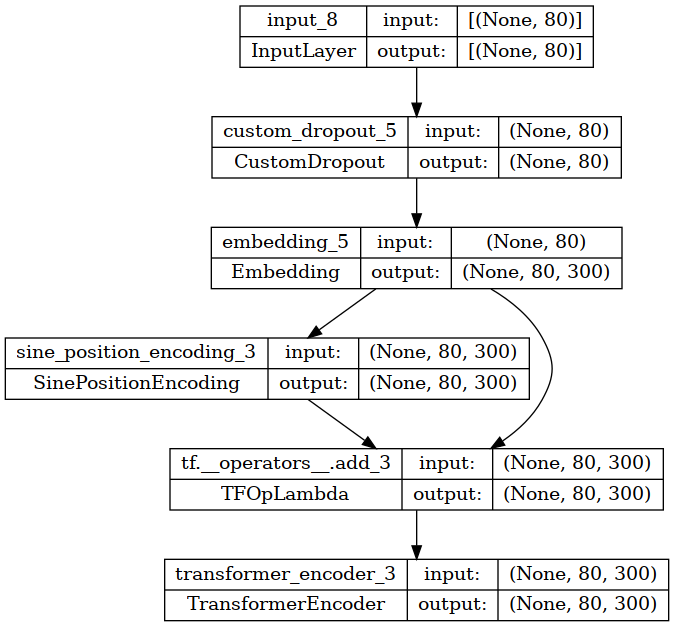

In [41]:
encoder_inputs = Input(shape=(input_pad_len,))
x = CustomDropout(1.0, 0.05)(encoder_inputs)
# x = PositionalEmbedding(input_pad_len, num_input_words + 1, embedding_size)(encoder_inputs)
encoder_embedding = Embedding(input_dim = num_input_words + 1, output_dim = embedding_size, mask_zero = True, weights = [input_embedding_matrix], trainable = False)(x)
encoder_pos_encoding = SinePositionEncoding()(encoder_embedding)
x = encoder_embedding + encoder_pos_encoding
encoder_outputs = TransformerEncoder(embedding_size, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

utils.plot_model(encoder, show_shapes=True, expand_nested=True)

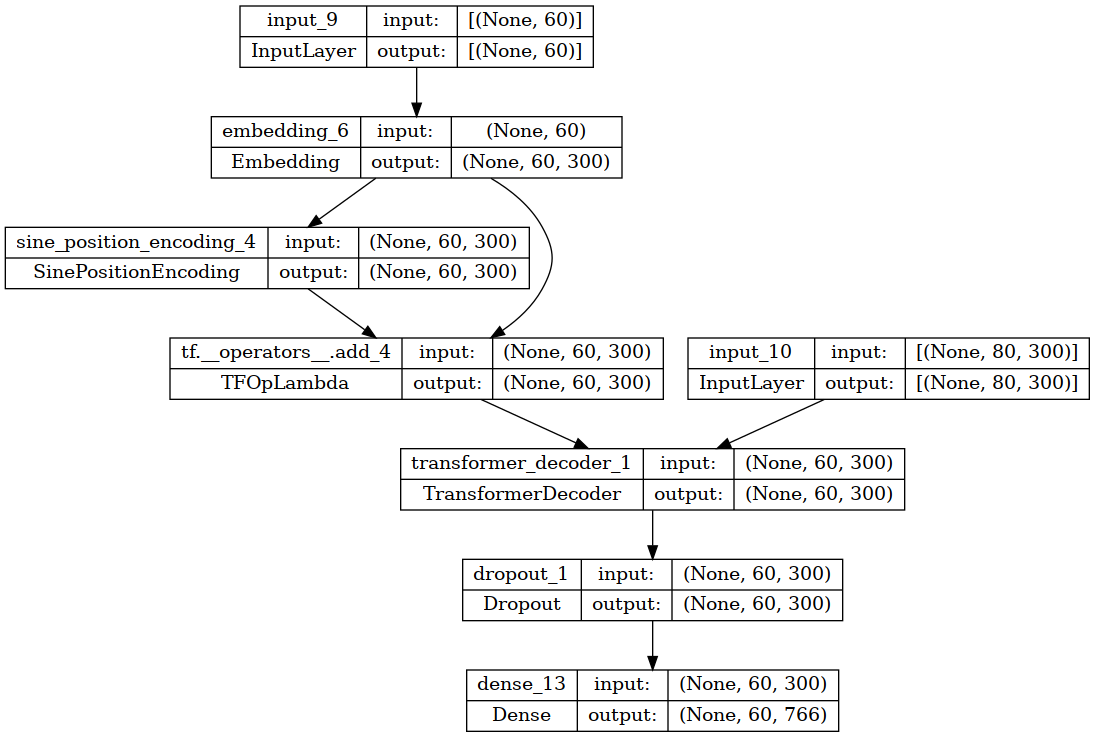

In [42]:
decoder_inputs = Input(shape=(target_pad_len,))
encoded_seq_inputs = Input(shape=(input_pad_len, embedding_size))
# x = PositionalEmbedding(target_pad_len, num_target_words + 1, embedding_size)(decoder_inputs)
decoder_embedding = Embedding(input_dim = num_input_words + 1, output_dim = embedding_size, mask_zero = True, trainable = True)(decoder_inputs)
decoder_pos_encoding = SinePositionEncoding()(decoder_embedding)
x = decoder_embedding + decoder_pos_encoding
x = TransformerDecoder(embedding_size, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(num_target_words + 1, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

utils.plot_model(decoder, show_shapes=True, expand_nested=True)

In [43]:
decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 custom_dropout_5 (CustomDr  (None, 80)                   0         ['input_8[0][0]']             
 opout)                                                                                           
                                                                                                  
 embedding_5 (Embedding)     (None, 80, 300)              636600    ['custom_dropout_5[0][0]']    
                                                                                                  
 sine_position_encoding_3 (  (None, 80, 300)              0         ['embedding_5[0][0]'

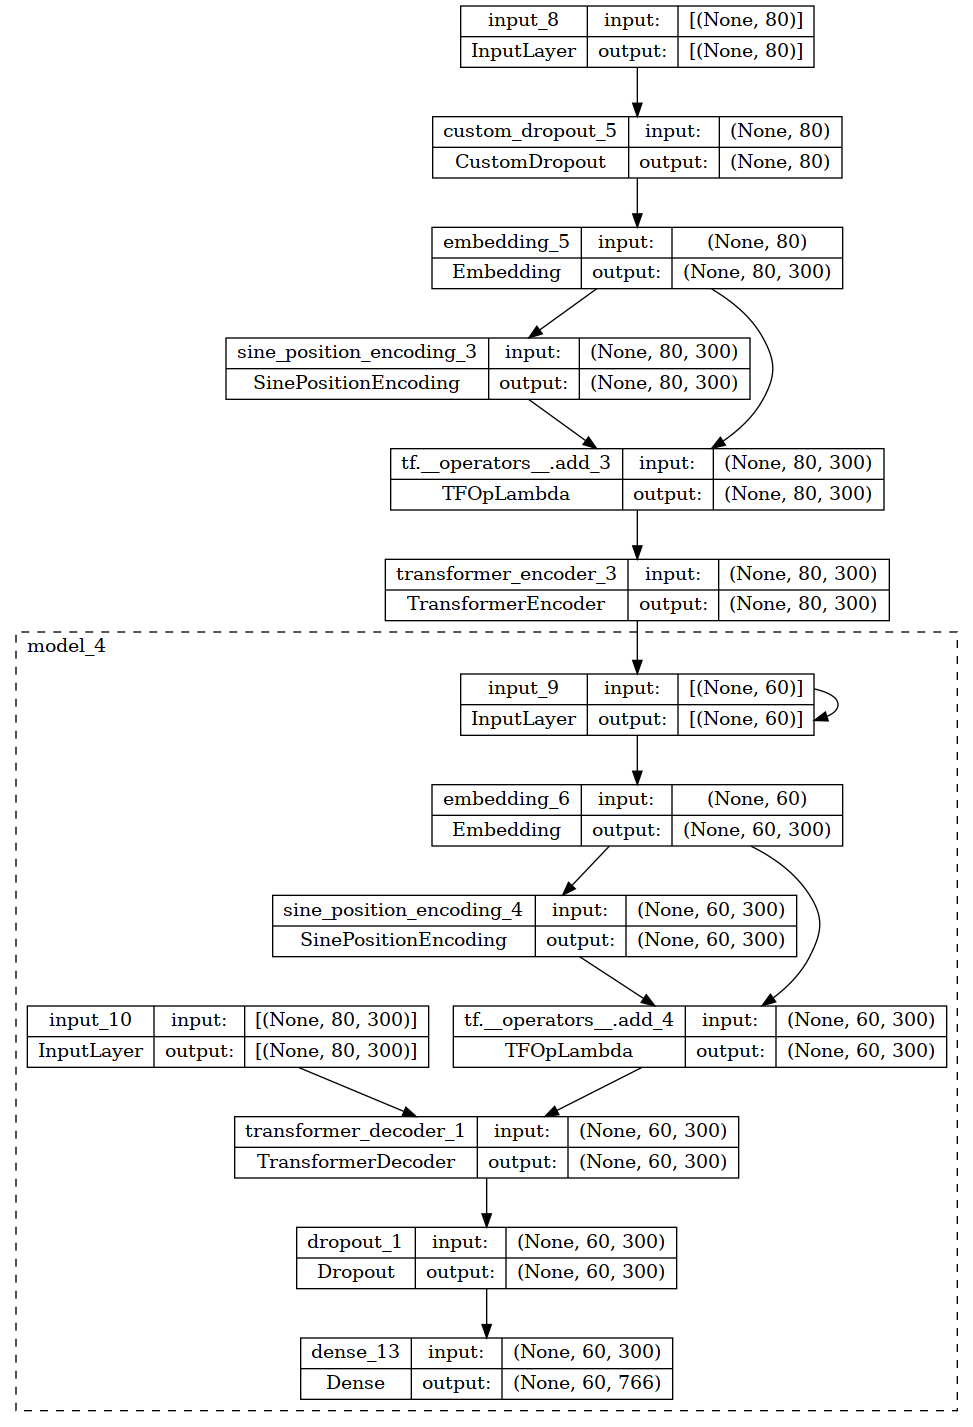

In [44]:
utils.plot_model(transformer, show_shapes=True, expand_nested=True)

In [45]:
transformer.compile(optimizer = Adam(0.0005), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
batch_size = 64
epochs = 50

In [46]:
checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

In [47]:
history = transformer.fit([encoder_input_data, decoder_input_data], decoder_output_data, epochs = epochs, batch_size = batch_size, validation_split = 0.1, callbacks = [checkpoint])

Epoch 1/50
100/100 [==============================] - 9s 55ms/step - loss: 1.0347 - acc: 0.8424 - val_loss: 0.7429 - val_acc: 0.8659
Epoch 2/50
100/100 [==============================] - 3s 31ms/step - loss: 0.7743 - acc: 0.8636 - val_loss: 0.7102 - val_acc: 0.8674
Epoch 3/50
100/100 [==============================] - 3s 30ms/step - loss: 0.7233 - acc: 0.8668 - val_loss: 0.6597 - val_acc: 0.8732
Epoch 4/50
100/100 [==============================] - 3s 28ms/step - loss: 0.6811 - acc: 0.8713 - val_loss: 0.6249 - val_acc: 0.8788
Epoch 5/50
100/100 [==============================] - 3s 30ms/step - loss: 0.6388 - acc: 0.8769 - val_loss: 0.5871 - val_acc: 0.8834
Epoch 6/50
100/100 [==============================] - 3s 29ms/step - loss: 0.5992 - acc: 0.8822 - val_loss: 0.5536 - val_acc: 0.8896
Epoch 7/50
100/100 [==============================] - 3s 28ms/step - loss: 0.5681 - acc: 0.8863 - val_loss: 0.5261 - val_acc: 0.8923
Epoch 8/50
100/100 [==============================] - 3s 27ms/step - 

In [48]:
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch:",str(best_epoch+1) + "/" + str(epochs))
print("loss:",history.history['loss'][best_epoch])
print("acc:",history.history['acc'][best_epoch])
print("val_loss:",history.history['val_loss'][best_epoch])
print("val_acc:",history.history['val_acc'][best_epoch])

Best epoch: 32/50
loss: 0.33051249384880066
acc: 0.9231078624725342
val_loss: 0.4099176228046417
val_acc: 0.9147417545318604


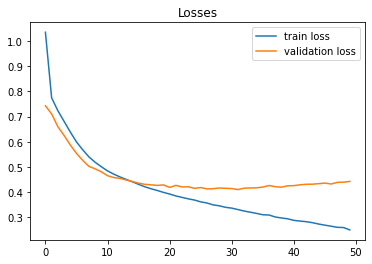

In [49]:
epochs_vals = range(0, epochs)
losses=history.history['loss']
val_losses=history.history['val_loss']
plt.title('Losses')
plt.plot(epochs_vals, losses, label='train loss')
plt.plot(epochs_vals, val_losses, label='validation loss')
plt.legend(loc='best')
plt.show()

In [50]:
def translate(input_sentences):
    input_sentences = [input_sentence.replace('.', '').replace(',', '').replace('!','').replace('"','').replace('?','').lower() for input_sentence in input_sentences]
    data_length = len(input_sentences)
    target_placeholder_sentences = ['']*data_length
    encoder_input_data, _, _ = create_model_data(input_sentences, target_placeholder_sentences, input_word_index, target_word_index, input_pad_len, target_pad_len)
    encoder_final_state = encoder.predict(encoder_input_data, verbose = 0)
    decoder_input_data = np.zeros((data_length, 1)) + target_word_index['<Start>']
    decoder_state = encoder_final_state
    decoder_output = np.zeros((data_length, target_pad_len - 1))
    for i in range(target_pad_len - 1):
        decoder_output_temp = decoder.predict([decoder_input_data, decoder_state], verbose = 0)
        next_words = np.argmax(decoder_output_temp, axis = -1)
        decoder_input_data = next_words
        decoder_output[:, i] = next_words.reshape((data_length,))
    output_sentences = [' '.join(inverted_target_word_index[num] for num in output_sentence) for output_sentence in decoder_output]
    output_sentences = [output_sentence.split('<End>',1)[0].replace(' - ','-') for output_sentence in output_sentences]
    return output_sentences

In [52]:
#LANG ZEIT REGION HOCH KOMMEN OST KOMMEN SONST REGION DEUTSCH STARK RUHIG AUCH TEILWEISE FREUNDLICH SONNE <End>
translate(['gleichzeitig weitet sich das hoch über der britannie weiter nach osten aus und beschert uns morgen in weiten teilen deutschlands ruhiges teilweise auch freundliches wetter'])

['HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH KOMMEN HOCH']